# Deep Deterministic Policy Gradient for Portfolio Management

**Steps to try:**
1. We first try to overfit a 3 stocks toy case using 3 years of training data.
2. Try to generalize to other years of the same stock.
3. Get some insigts on network topology and hyperparameter tuning.
4. Increase the number of stocks. (Increase action space to more than 10.)

**Possible improvement methods:**
1. Use correlated action noise
2. Use adaptive parameter noise

**Figures to show:**
1. Training: total rewards w.r.t episode
2. How the model performs on training data
3. How the model performs on testing data

## Setup

In [1]:
# for compatible with python 3
from __future__ import print_function

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from utils.sector_data import read_sector_history, index_to_date, date_to_index, normalize
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
# dataset for 9 sectors by splitting timestamp
history, abbreviation = read_sector_history(filepath='utils/datasets/sectors_history_target.h5')
history = history[:, :, :4]

# 9 sectors are all involved. We choose first 3 years as training data
num_training_time = 1095
target_sectors = abbreviation
target_history = np.empty(shape=(len(target_sectors), num_training_time, history.shape[2]))

for i, sector in enumerate(target_sectors):
    target_history[i] = history[abbreviation.index(sector), :num_training_time, :]

# and last 2 years as testing data.
testing_sectors = abbreviation
testing_history = np.empty(shape=(len(testing_sectors), history.shape[1] - num_training_time,
                               history.shape[2]))
for i, sector in enumerate(testing_sectors):
    testing_history[i] = history[abbreviation.index(sector), num_training_time:, :]

In [4]:
nb_classes = len(target_sectors) + 1
print(target_history.shape)
print(testing_history.shape)

(9, 1095, 4)
(9, 730, 4)


In [5]:
# visualize 3 sector open price
if False:
    date_list = [index_to_date(i) for i in range(target_history.shape[1])]
    x = range(target_history.shape[1])
    for i in range(len(target_sectors)):
        plt.figure(i)
        plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
        plt.xticks(x[::200], date_list[::200], rotation=30)
        plt.title(target_sectors[i])
        plt.show()

## Load Models

In [6]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from sector_ls_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope, test_model_multiple

from model.supervised.lstm import StockLSTM
from model.supervised.cnn import StockCNN

/Users/satyen/opt/anaconda3/envs/portfolio/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/satyen/opt/anaconda3/envs/portfolio/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/satyen/opt/anaconda3/envs/portfolio/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/satyen/opt/anac

Using TensorFlow backend.


In [7]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

In [8]:
models = []
model_names = []
# window_length_lst = [3, 7, 14, 21]
window_length_lst = [3]
# predictor_type_lst = ['cnn', 'lstm']
predictor_type_lst = ['cnn']
use_batch_norm = True

In [9]:
# instantiate environment, 9 sectors, with trading cost, window_length 3, start_date sample each time
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type,
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(),
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/sector.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=False)
            models.append(ddpg_model)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.




Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from weights/ls_sector/cnn/window_3/batch_norm/checkpoint.ckpt


#### Note that the following tests use the dataset from the following cell. To run the original dataset, you have to change the date or simulation steps in order to avoid exceptions.

In [10]:
# create another dataset
history, abbreviation = read_sector_history(filepath='utils/datasets/sectors_history_target.h5')
history = history[:, :, :4]
nb_classes = len(history) + 1
print(history.shape)
testing_history = history
testing_sectors = abbreviation
target_history = history
target_sectors = abbreviation

(9, 1825, 4)


In [11]:
from environment.portfolio import PortfolioEnv, MultiActionLsPortfolioEnv
# env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[8:], steps=1500,
#                               sample_start_date='2012-10-30')
env = MultiActionLsPortfolioEnv(target_history, target_sectors, model_names[:], steps=1500,
                              sample_start_date='2015-03-17')

<Figure size 720x432 with 0 Axes>

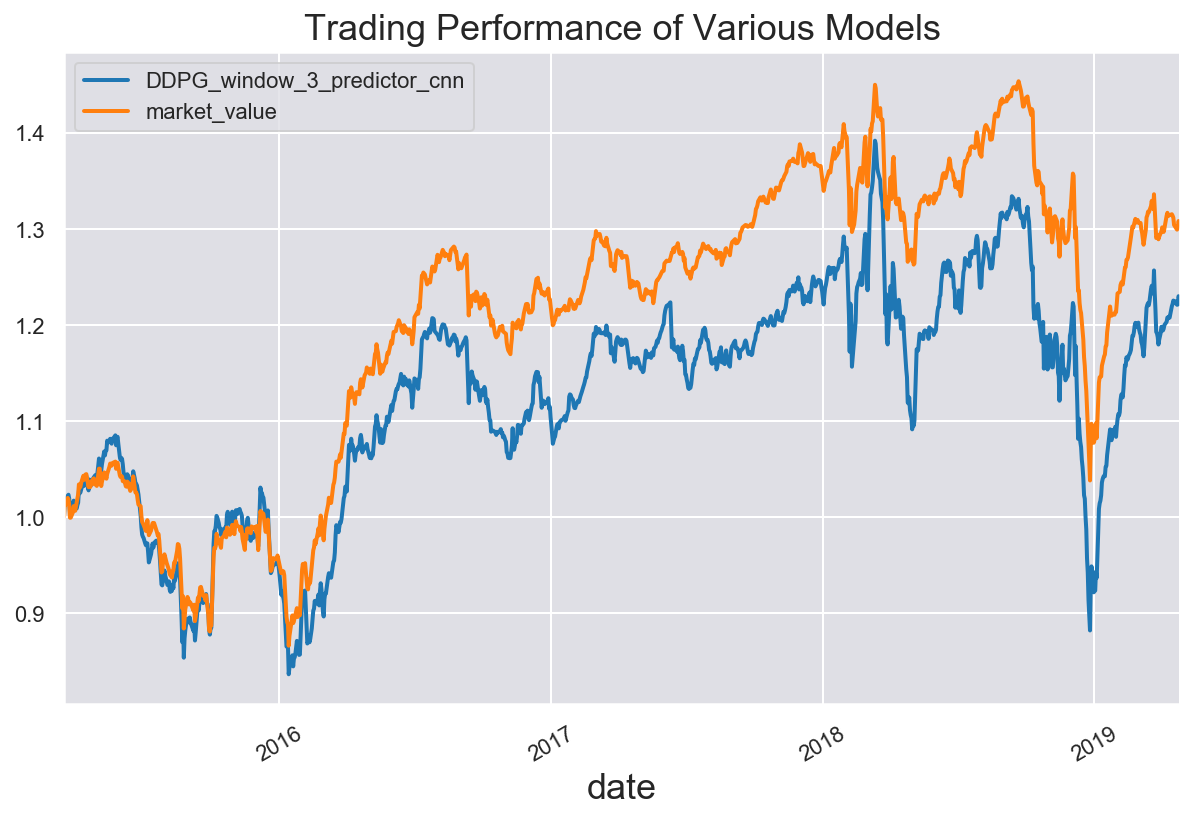

In [12]:
test_model_multiple(env, models[:])

In [13]:
# evaluate the model with unseen data from same sector, fixed the starting date
env = MultiActionLsPortfolioEnv(testing_history, testing_sectors, model_names[:], steps=650, 
                              start_idx=num_training_time, sample_start_date='2018-02-20')

<Figure size 720x432 with 0 Axes>

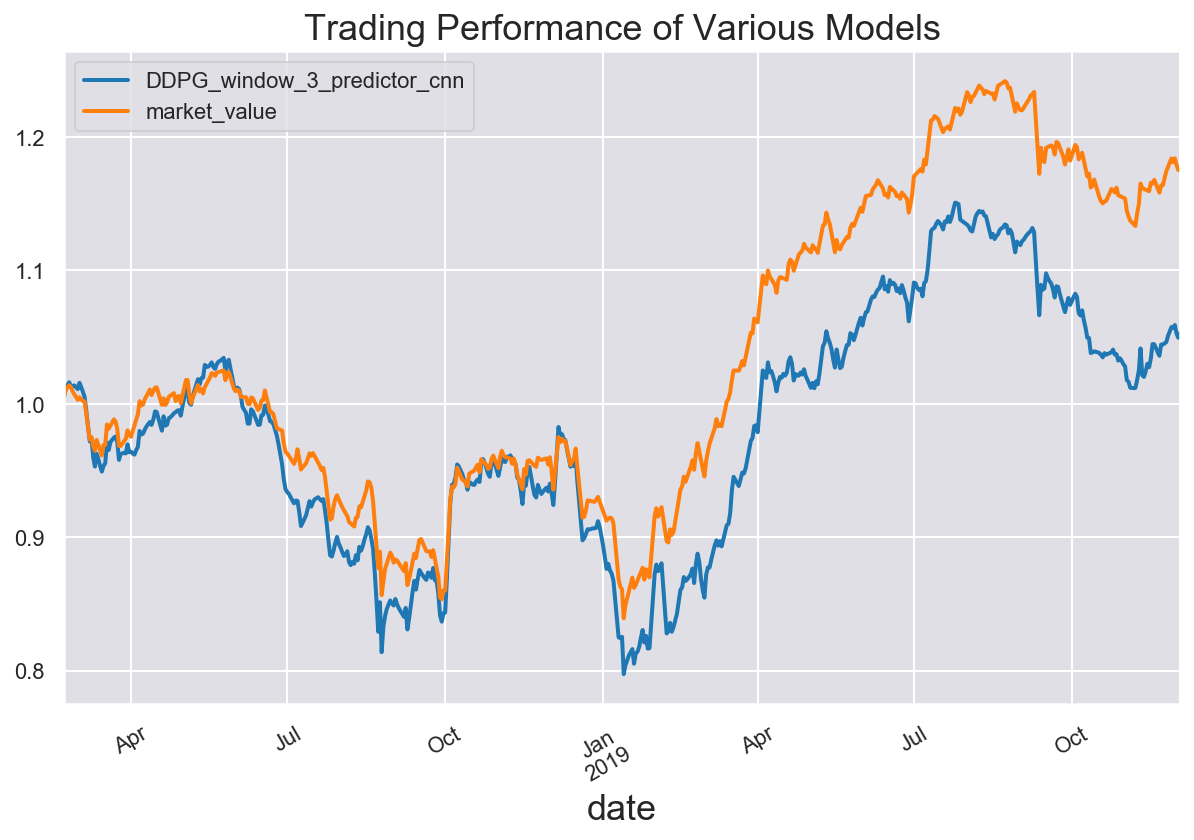

In [14]:
# test on CNN predictor, with batch norm and window length of 3
test_model_multiple(env, models[:])